In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
# Load and Normalize the data
t = transforms.Compose([transforms.ToTensor(),
                        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])   # means and std for each channel

train_data = datasets.CIFAR10(root='CIFAR10_Dataset', train=True, download = True, transform=t)
test_data = datasets.CIFAR10(root='CIFAR10_Dataset', train=False, download = False, transform=t)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


Extracting CIFAR10_Dataset/cifar-10-python.tar.gz to CIFAR10_Dataset


In [3]:
train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=100, shuffle=True)

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

truck


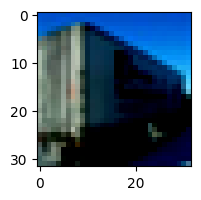

In [5]:
# Visualizing the normalized data
img, label = train_data[15]
plt.figure(figsize=(2, 2))
plt.imshow(img.permute(1, 2, 0))
print(classes[label])

In [6]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    break

torch.Size([100, 3, 32, 32])
torch.Size([100])


In [7]:
# Regular Neural Network
class ImageClassifier(nn.Module):

    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.layer1 = nn.Linear(32*32*3, 512)
        self.layer2 = nn.Linear(512, 256)
        self.layer3 = nn.Linear(256, 10)
        self.dropout1 = nn.Dropout(0.4)     # Drop out 40% of the neurons
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)
        self.batch_norm1 = nn.BatchNorm1d(512)      # Normalize the output from layer 1
        self.batch_norm2 = nn.BatchNorm1d(256)      # Normalize the output from layer 2

    def forward(self, img_batch):
        activation1 = F.relu(self.batch_norm1(self.layer1(self.dropout1(img_batch))))
        activation2 = F.relu(self.batch_norm2(self.layer2(self.dropout2(activation1))))
        output = self.layer3(self.dropout3(activation2))
        return output

# Convolutional Neural Network
class ImageClassifier2(nn.Module):

    def __init__(self):
        super(ImageClassifier2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        # 32 + 2(1) - 3 + 1 = 32  (see formula in pytorch documentation)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32 / 2 = 16
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        # 16 + 2(1) - 3 + 1 = 16
        # pooling layer: 16 / 2 = 8
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # 8 + 2(1) - 3 + 1 = 8
        # pooling layer: 8 / 2 = 4
        # final shape = (100, 64, 4, 4)
        self.linear1 = nn.Linear(4*4*64, 500)
        self.dropout = nn.Dropout(0.2)
        self.linear2 = nn.Linear(500, 10)

    def forward(self, img_batch):
        a = F.relu(self.conv1(img_batch))
        a = self.pool(a)
        a = F.relu(self.conv2(a))
        a = self.pool(a)
        a = F.relu(self.conv3(a))
        a = self.pool(a)
        a = F.relu(self.linear1(a.flatten(1)))           # flatten the last three dimensions of the tensor
        output = self.linear2(self.dropout(a))
        return output

In [8]:
b = torch.ones(100, 2, 5, 5)
b = b.flatten(1)
b.shape

torch.Size([100, 50])

In [9]:
def train(dataset, loader, model, crit, optimizer, epochs):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # pick the GPU if it is available
    print("Device:", device)
    model = model.to(device)          # passes the model to the selected device
    model.train()                     # sets the model into training mode

    for epoch in range(epochs):
        full_loss = 0.0
        n_correct = 0

        for img_batch, labels in tqdm(loader):      # tqdm displays a progress bar as we iterate through the loop
            img_batch = img_batch.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model.forward(img_batch)
            predicted = outputs.argmax(dim=1)
            loss = crit(outputs, labels)
            loss.backward()
            optimizer.step()

            # we want the loss for every single training example so that we can calculate the average loss over the entire dataset
            full_loss += loss.item() * len(labels)
            n_correct += (predicted == labels.data).sum()     # keep track of the number of correct predictions to calculate accuracy

        average_loss = full_loss / len(dataset)
        accuracy = n_correct / len(dataset) * 100

        print(f"Epoch {epoch+1} training average loss: {average_loss:.3f}",
              f"with {accuracy:.2f}% accuracy")


def test(dataset, loader, model):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')   # pick the GPU if it is available
    print("Device:", device)
    model = model.to(device)
    model.eval()        # set the model to testing mode

    n_correct = 0
    with torch.no_grad():                       #torch.no_grad() disables computing gradients
        for img_batch, labels in tqdm(loader):
            img_batch = img_batch.to(device)
            labels = labels.to(device)
            outputs = model(img_batch)
            predicted = outputs.argmax(dim=1)
            n_correct += (predicted == labels.data).sum()

    accuracy = n_correct / len(dataset) * 100
    print(f"Test accuracy: {accuracy:.2f}%")

In [10]:
model = ImageClassifier2()
crit = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [11]:
for _ in range(5):
    train(train_data, train_loader, model, crit, optimizer, 3)
    test(test_data, test_loader, model)

Device: cuda:0


100%|██████████| 500/500 [00:17<00:00, 28.54it/s]


Epoch 1 training average loss: 1.873 with 31.13% accuracy


100%|██████████| 500/500 [00:17<00:00, 29.40it/s]


Epoch 2 training average loss: 1.371 with 50.25% accuracy


100%|██████████| 500/500 [00:16<00:00, 30.49it/s]


Epoch 3 training average loss: 1.142 with 59.15% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:02<00:00, 35.46it/s]


Test accuracy: 64.06%
Device: cuda:0


100%|██████████| 500/500 [00:17<00:00, 29.00it/s]


Epoch 1 training average loss: 0.982 with 65.45% accuracy


100%|██████████| 500/500 [00:16<00:00, 30.45it/s]


Epoch 2 training average loss: 0.863 with 69.68% accuracy


100%|██████████| 500/500 [00:16<00:00, 30.43it/s]


Epoch 3 training average loss: 0.771 with 73.05% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:03<00:00, 31.93it/s]


Test accuracy: 70.25%
Device: cuda:0


100%|██████████| 500/500 [00:16<00:00, 29.45it/s]


Epoch 1 training average loss: 0.700 with 75.43% accuracy


100%|██████████| 500/500 [00:16<00:00, 30.26it/s]


Epoch 2 training average loss: 0.627 with 78.04% accuracy


100%|██████████| 500/500 [00:16<00:00, 30.17it/s]


Epoch 3 training average loss: 0.565 with 80.07% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:03<00:00, 31.32it/s]


Test accuracy: 72.92%
Device: cuda:0


100%|██████████| 500/500 [00:16<00:00, 30.58it/s]


Epoch 1 training average loss: 0.503 with 82.34% accuracy


100%|██████████| 500/500 [00:16<00:00, 30.83it/s]


Epoch 2 training average loss: 0.444 with 84.34% accuracy


100%|██████████| 500/500 [00:26<00:00, 18.65it/s]


Epoch 3 training average loss: 0.397 with 86.05% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:06<00:00, 15.36it/s]


Test accuracy: 74.15%
Device: cuda:0


100%|██████████| 500/500 [00:26<00:00, 18.70it/s]


Epoch 1 training average loss: 0.347 with 87.72% accuracy


100%|██████████| 500/500 [00:29<00:00, 16.72it/s]


Epoch 2 training average loss: 0.299 with 89.46% accuracy


100%|██████████| 500/500 [00:33<00:00, 14.85it/s]


Epoch 3 training average loss: 0.261 with 90.83% accuracy
Device: cuda:0


100%|██████████| 100/100 [00:03<00:00, 25.29it/s]

Test accuracy: 74.12%


**Saving the trained model**

In [12]:
# Saving the trained model
PATH = "CIFAR10_Dataset/trained_model.pth"
torch.save(model.state_dict(), PATH)

In [13]:
# Loading the saved model
model = ImageClassifier2()
model.load_state_dict(torch.load(PATH))

# Test the loaded model
test(test_data, test_loader, model)

<ipython-input-13-78951bd080f1>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(PATH))


Device: cuda:0


100%|██████████| 100/100 [00:04<00:00, 22.17it/s]

Test accuracy: 74.12%


**For Demonstration**

In [18]:
data = datasets.CIFAR10(root='CIFAR10_Dataset', train=False, download = False, transform=transforms.ToTensor())
data_loader = DataLoader(dataset=data, batch_size=1000, shuffle=True)
data_iter = iter(data_loader)
images, labels = next(data_iter)
images, labels = images.cuda(), labels.cuda()

In [19]:
outputs = model(images)
predicted = outputs.argmax(dim=1)

Actual: cat
Predicted: cat


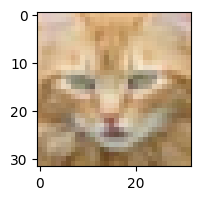

In [47]:
import random

i = random.randint(0, len(labels) - 1)
img, label = images[i].cpu(), labels[i].cpu()
plt.figure(figsize=(2, 2))
plt.imshow(img.permute(1, 2, 0))
print(f"Actual: {classes[label]}")
print(f"Predicted: {classes[predicted[i]]}")